In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
import desisim.quickcat
from astropy.io import fits
from astropy.table import Table, Column, vstack
import json
import shutil
import healpy
import targets


from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
import subprocess

%matplotlib inline

# Global statistics

In [2]:
def consolidate_favail(fba_files):
    # getting all the targetids of the assigned fibers
    print('reading individual fiberassign files')
    favail = list()
    for i_tile, tile_file in enumerate(fba_files):
        if i_tile%50 ==0:
            print(i_tile)
        id_favail, header = fits.getdata(tile_file, 'FAVAIL', header=True)
        favail.extend(id_favail['TARGETID'])
    return list(set(favail))

def global_efficiency(targets, id_avail, zcat, target_class='QSO', zcat_spectype='QSO', z_max=None, z_min=None):
    ii_avail = np.in1d(targets['TARGETID'], id_avail)
    targets_avail = targets[ii_avail]

    if z_max is None and z_min is None:
        sub_zcat = zcat.copy()
    elif (z_min is not None) or (z_max is not None):
        if z_max is not None:
            sub_zcat = zcat[zcat['Z']<z_max]
        if z_min is not None:
            sub_zcat = zcat[zcat['Z']>z_min]
    else:
        print("Error")
        sub_zcat = None

    # input target consistent with target_class
    is_class = (targets_avail['DESI_TARGET'] & desi_mask.mask(target_class))!=0
    targets_avail_class = targets_avail[is_class]
    n_avail = len(targets_avail_class)

    # output in the redshift catalog consistent with truth_spectype
    sub_zcat_class = sub_zcat[sub_zcat['SPECTYPE']==zcat_spectype]
    
    # keep the elements in the zcat that correspond to the correct input target class
    id_intersection = np.in1d(sub_zcat_class['TARGETID'], targets_avail_class['TARGETID'])
    sub_zcat_class = sub_zcat_class[id_intersection]
    n_assigned = len(sub_zcat_class)

    nobs = dict()
    for i in range(10):
        nobs[i] = np.count_nonzero(sub_zcat_class['NUMOBS']==i)
    nobs[0] = (n_avail - n_assigned)

    print(target_class, zcat_spectype, n_assigned/n_avail, n_avail, n_assigned, nobs)
    
def tile_efficiency(qa_json_file):
    f = open(qa_json_file)
    qa_dict = json.load(f)
    f.close()
    assign_total = []
    assign_science= []
    assign_sky = []
    assign_std = []
    for k in qa_dict:
        assign_total.append(qa_dict[k]['assign_total'])
        assign_science.append(qa_dict[k]['assign_science'])
        assign_sky.append(qa_dict[k]['assign_sky'])
        assign_std.append(qa_dict[k]['assign_std'])
    assign_total = np.array(assign_total)
    assign_science = np.array(assign_science)
    assign_sky = np.array(assign_sky)
    assign_std = np.array(assign_std)
    n_not_enough_sky = np.count_nonzero(assign_sky<400)
    n_not_enough_std = np.count_nonzero(assign_std<100)
    f_unassigned = (5000 - assign_total)/5000
    print(n_not_enough_sky, n_not_enough_std, np.median(f_unassigned))

In [3]:
! mkdir strategy_A/fiberassign_full
! cp strategy_A/fiberassign_dark0/tile*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_dark1/tile*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_dark2_dark3/tile*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_gray/tile*.fits strategy_A/fiberassign_full/
! fba_run_qa --dir strategy_A/fiberassign_full/

mkdir: cannot create directory ‘strategy_A/fiberassign_full’: File exists
INFO: Loaded focalplane for time stamp 2019-10-01 15:15:02.318497
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Found 0 fiberassign tile files
INFO: Selecting 0 fiberassign tile files


In [4]:
fba_files_A = glob.glob('strategy_A/fiberassign_full/tile-*fits')
favail_A = consolidate_favail(fba_files_A)
zcat_A = Table.read('strategy_A/zcat/dark2_dark3_zcat.fits')
#tile_efficiency('strategy_A/fiberassign_full/qa.json')
targets = Table.read("targets/subset_dr8_mtl_dark_gray_NGC.fits")
truth = Table.read("targets/subset_truth_dr8_mtl_dark_gray_NGC.fits")
targets.sort(keys='TARGETID')
zcat_A.sort(keys='TARGETID')
truth.sort(keys='TARGETID')


reading individual fiberassign files
0
50
100
150
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800


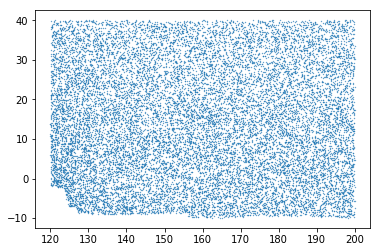

In [5]:
n_targets = len(targets)
r = np.random.random(n_targets)
rr = r<0.001
plt.scatter(targets['RA'][rr], targets['DEC'][rr], s=0.1)

In [6]:
ii = (targets['RA']>140.0) & (targets['RA']<180.0) & (targets['DEC']>10.0) & (targets['DEC']<20)
small_targets = targets[ii]

In [7]:
global_efficiency(small_targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO')
global_efficiency(small_targets, favail_A, zcat_A, target_class='LRG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_A, zcat_A, target_class='ELG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO', z_min=2.15)
global_efficiency(small_targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO', z_max=2.15)

QSO QSO 0.9863167380869181 108746 107258 {0: 1488, 1: 78197, 2: 11188, 3: 4064, 4: 13806, 5: 2, 6: 1, 7: 0, 8: 0, 9: 0}
LRG GALAXY 0.9529158496035468 187664 178828 {0: 8836, 1: 134306, 2: 44522, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
ELG GALAXY 0.7108614254463494 1009803 717830 {0: 291973, 1: 717830, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.17265922424732863 108746 18776 {0: 89970, 1: 336, 2: 973, 3: 3681, 4: 13784, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0}
QSO QSO 0.8136575138395895 108746 88482 {0: 20264, 1: 77861, 2: 10215, 3: 383, 4: 22, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0}


In [8]:
fba_files_A_0 = glob.glob('strategy_A/fiberassign_gray/tile-*fits')
favail_A_0 = consolidate_favail(fba_files_A_0)
zcat_A_0 = Table.read('strategy_A/zcat/gray_zcat.fits')
targets = Table.read("targets/subset_dr8_mtl_dark_gray_NGC.fits")
truth = Table.read("targets/subset_truth_dr8_mtl_dark_gray_NGC.fits")
zcat_A_0.sort(keys='TARGETID')


reading individual fiberassign files
0
50
100
150
200
250
300
350


In [9]:
global_efficiency(small_targets, favail_A_0, zcat_A_0, target_class='QSO', zcat_spectype='QSO')
global_efficiency(small_targets, favail_A_0, zcat_A_0, target_class='LRG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_A_0, zcat_A_0, target_class='ELG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_A_0, zcat_A_0, target_class='QSO', zcat_spectype='QSO', z_min=2.15)
global_efficiency(small_targets, favail_A_0, zcat_A_0, target_class='QSO', zcat_spectype='QSO', z_max=2.15)

QSO QSO 0.9445536609829488 24925 23543 {0: 1382, 1: 20849, 2: 2694, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
LRG GALAXY 0.8307479498073312 20242 16816 {0: 3426, 1: 16816, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
ELG GALAXY 0.21406952008260152 931702 199449 {0: 732253, 1: 199449, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.16517552657973922 24925 4117 {0: 20808, 1: 3652, 2: 465, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.7793781344032096 24925 19426 {0: 5499, 1: 17197, 2: 2229, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [10]:
! mkdir strategy_B/fiberassign_full
! cp strategy_B/fiberassign_dark0/tile*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_dark1/tile*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_dark2_dark3/tile*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_gray/tile*.fits strategy_B/fiberassign_full/
! fba_run_qa --dir strategy_B/fiberassign_full/

mkdir: cannot create directory ‘strategy_B/fiberassign_full’: File exists
INFO: Loaded focalplane for time stamp 2019-10-01 15:29:50.141849
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Found 0 fiberassign tile files
INFO: Selecting 0 fiberassign tile files


In [11]:
fba_files_B = glob.glob('strategy_B/fiberassign_full/tile-*fits')
favail_B = consolidate_favail(fba_files_B)
zcat_B = Table.read('strategy_B/zcat/dark2_dark3_zcat.fits')
#tile_efficiency('strategy_B/fiberassign_full/qa.json')
targets.sort(keys='TARGETID')
zcat_B.sort(keys='TARGETID')
truth.sort(keys='TARGETID')

reading individual fiberassign files
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800


In [12]:
global_efficiency(small_targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO')
global_efficiency(small_targets, favail_B, zcat_B, target_class='LRG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_B, zcat_B, target_class='ELG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO', z_min=2.15)
global_efficiency(small_targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO', z_max=2.15)

QSO QSO 0.9863075423463852 108746 107257 {0: 1489, 1: 78338, 2: 11035, 3: 4067, 4: 13813, 5: 3, 6: 1, 7: 0, 8: 0, 9: 0}
LRG GALAXY 0.9528039474806036 187664 178807 {0: 8857, 1: 134294, 2: 44513, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
ELG GALAXY 0.7195383654039451 1009803 726592 {0: 283211, 1: 726592, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.17265922424732863 108746 18776 {0: 89970, 1: 335, 2: 972, 3: 3685, 4: 13782, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0}
QSO QSO 0.8136483180990565 108746 88481 {0: 20265, 1: 78003, 2: 10063, 3: 382, 4: 31, 5: 2, 6: 0, 7: 0, 8: 0, 9: 0}


In [ ]:
truth[:10]

In [ ]:
avail_a_array = np.array([favail_A])
avail = Table(np.transpose(avail_a_array), names=(['TARGETID']))
avail.write("available.fits", overwrite=True)
avail = Table.read("available.fits")

In [ ]:
compiled = targets.copy()
ii = np.in1d(targets['TARGETID'], avail['TARGETID'])
compiled = targets[ii]

compiled['NUMOBS'] = np.zeros(len(compiled), dtype=int)
compiled['Z'] = np.zeros(len(compiled))
compiled['TRUEZ'] = np.zeros(len(compiled), dtype=int)
compiled['TRUESPECTYPE'] = np.repeat('A', len(compiled))

ii_from_z = np.in1d(compiled['TARGETID'], zcat['TARGETID'])
compiled['Z'][ii_from_z] = zcat['Z']
compiled['NUMOBS'][ii_from_z] = np.int_(zcat['NUMOBS'])

ii_from_truth = np.in1d(truth['TARGETID'], compiled['TARGETID'])
compiled['TRUESPECTYPE'] = truth['TRUESPECTYPE'][ii_from_truth]
compiled['TRUEZ'] = truth['TRUEZ'][ii_from_truth]
compiled[['RA', 'DEC', 'TARGETID', 'DESI_TARGET', 'NUMOBS', 'TRUESPECTYPE', 'TRUEZ']].write("myzcat_strategy_A.fits", overwrite=True)

In [ ]:
compiled=Table.read("myzcat_strategy_A.fits")

In [ ]:
rr = np.random.random(len(compiled))
ii = rr<0.01
plt.scatter(compiled['RA'][ii], compiled['DEC'][ii], s=0.1)

In [ ]:
compiled